## 0. Objetivo

### Analisis del mismo modelo sobre los mismos datos pero con distintas estrategias de compilacion del modelo con la libreria Tensorflow


## Arquitectura, version Cuda...

In [1]:
!nvidia-smi

Fri Jul 25 11:14:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.88                 Driver Version: 576.88         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 960       WDDM  |   00000000:01:00.0 Off |                  N/A |
| 24%   40C    P8             19W /  160W |    1037MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Seguidamente establecemos una strategia global de espejp con la gpu y una reserva que haremos en la ram

In [3]:
import tensorflow as tf

tf.debugging.set_log_device_placement(False)
gpus = tf.config.list_logical_devices('GPU')
strategy0 = tf.distribute.MirroredStrategy(gpus)
strategy1 = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.NcclAllReduce())
strategy2 = tf.distribute.MirroredStrategy(devices=gpus.append([tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]), cross_device_ops=tf.distribute.ReductionToOneDevice(), )

tf.test.is_gpu_available()
tf.test.is_built_with_cuda()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

Comprobamos

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPU


In [5]:
# Importar bibliotecas necesarias

import os
from openpyxl import load_workbook

import numpy as np  # Para trabajar con arreglos numéricos y generar datos sintéticos
import matplotlib.pyplot as plt  # Para graficar resultados
import seaborn as sns  # Para crear gráficos más atractivos
from sklearn.metrics import confusion_matrix  # Para analizar errores con una matriz de confusión
from sklearn.model_selection import train_test_split  # Para dividir los datos en entrenamiento y validación

import pandas as pd
# Estas son herramientas para construir, entrenar y evaluar redes neuronales.
import keras as keras  # Biblioteca para trabajar con redes neuronales
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2



#------------------------------------------------
import sklearn

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler  # Para escalar los datos
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
from time import time

In [6]:

# Fijar semillas para reproducibilidad
SEED = 5785630 #random.randint(0,100000)	  # Generar un número aleatorio entre 0 y 1000
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
sklearn.random.seed(SEED)
print(f"Seed: {SEED}")  # Imprimir la semilla utilizada

Seed: 5785630


In [7]:
def reparar_nombres(file):
    import os

    if " " in file:
        os.rename(file, file.replace(" ", "_"))
    return file.replace(" ", "_")


scores = {}

In [8]:
# pillar los xls de la carpeta y los mete en un dataframe conjunto

path = "./"
archivos = [x for x in os.listdir(path) if x.endswith(".xlsx")]
df = pd.DataFrame()
df_cols = ""
for archivo in archivos:
    archivo = reparar_nombres(archivo)

    archivo = path + str(archivo)

    xlsx = load_workbook(archivo)

    paginas = xlsx.sheetnames

    dfx = pd.read_excel(archivo, sheet_name=paginas[0])

    dfy = pd.read_excel(archivo, sheet_name=paginas[1])


    df_tmp = pd.concat([dfx, dfy], axis=1)
    if len(df.columns) != 0:
        df.columns = df_tmp.columns
    df = pd.concat([df, df_tmp], axis=0, ignore_index=True)

df = df.dropna(axis=0, how="any")
df = df.drop_duplicates()
df.to_csv("df.csv", index=False)


In [9]:
df = pd.read_csv("df.csv")

In [10]:
dfx = df.iloc[:, :-8]
dfy = df.iloc[:, -8:]

In [11]:
import re

for i in dfy.columns:
    dfy[i] = dfy[i].apply(lambda x: x if type(x) is not str else float(re.sub(r'[^0-9.]', '', x)))

for i in dfx.columns:
    dfx[i] = dfx[i].apply(lambda x: x if type(x) is not str else float(re.sub(r'[^0-9.]', '', x)))

dfx = dfx.astype(float)
dfy = dfy.astype(float)

In [12]:
dfx.describe()

,380.0,380.5,381.0,381.5,382.0,382.5,383.0,383.5,384.0,384.5,...,775.0,775.5,776.0,776.5,777.0,777.5,778.0,778.5,779.0,779.5
count,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,...,671.000000,671.0,671.0,671.000000,671.0,671.0,671.0,671.0,671.0,671.0
mean,23.548903,27.147522,24.603996,24.852823,26.199975,27.165705,32.306966,30.009750,35.036629,32.437839,...,0.968703,0.0,0.0,0.149031,0.0,0.0,0.0,0.0,0.0,0.0
std,37.342702,46.220070,37.468848,36.315064,39.065509,43.198508,50.323903,45.720979,59.114661,45.700615,...,8.363955,0.0,0.0,3.860457,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,47.722500,50.000000,50.757500,50.000000,51.257000,54.919500,62.243000,62.397500,61.064000,63.599500,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
max,300.000000,500.000000,200.000000,300.000000,206.250000,400.000000,400.000000,500.000000,500.000000,400.000000,...,100.000000,0.0,0.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
dfy.describe()


,Grado Alcohólico Adquirido (%Vol),Ácidez Total Tartárica (g/L),pH,Ácidez Volátil Acética (g/L),Anhídrido Sulfuroso libre (mg/L),Anhídrido Sulfuroso Total (mg/L),Azúcares reductores (g/L),Ácido Málico (g/L)
count,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000
mean,12.735395,7.010462,3.180909,0.393472,10.306706,67.608048,1.970238,2.043070
std,0.528579,1.074549,0.090193,0.213059,7.684913,44.516237,3.922582,1.181123
min,11.120000,4.600000,3.040000,0.180000,5.000000,5.000000,0.170000,0.100000
25%,12.670000,6.370000,3.130000,0.300000,5.000000,36.000000,1.000000,1.300000
50%,12.880000,6.800000,3.160000,0.340000,5.000000,63.000000,1.400000,1.900000
75%,13.070000,7.560000,3.210000,0.410000,16.000000,85.000000,2.000000,2.800000
max,13.590000,9.610000,3.510000,1.560000,39.000000,192.000000,35.000000,4.400000


In [14]:

N_Datos = dfx.shape[0]  # Se generarán 81 ejemplos o muestras.
N_Dimensiones_entrada_X = dfx.shape[1]  # Cada muestra tendrá 800 características (dimensiones de entrada).
N_Dimensiones_salida_Y = dfy.shape[1]  # Habrá 8 clases posibles para la salida.

X = pd.DataFrame(dfx)  # Genera datos de entrada (X) de forma aleatoria con valores flotantes entre 0 y 1.
y = pd.DataFrame(dfy)  # Genera etiquetas de salida (Y) de forma aleatoria con valores enteros entre 0 y 9.


In [15]:


# --- Preprocesamiento ---
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, Y_train_scaled, Y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=SEED)



In [16]:
["mse" for _ in range(0, 8)]

['mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse']

In [17]:
import tensorflow as tf
print("Versión de TensorFlow:", tf.__version__)
print("GPUs detectadas:", tf.config.list_physical_devices('GPU'))


Versión de TensorFlow: 2.10.0
GPUs detectadas: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## GPU0

In [18]:

# --- Red neuronal regresora multisalida ---
start_time = time()
early = EarlyStopping(monitor='loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=15, factor=0.5)
with tf.device('/device:GPU:0'):
    # Definir el modelo
    model0 = Sequential(
        [
            InputLayer(input_shape=(N_Dimensiones_entrada_X,)),  # Capa de entrada con 8000 características
            BatchNormalization(),  # Normalización por lotes para mejorar la convergencia
            LeakyReLU(0.5),
            Dense(512, activation="leaky_relu", kernel_regularizer=l2(0.001)),  # Capa oculta con 1024 neuronas
            Dropout(0.2),  # Capa de abandono para evitar el sobreajuste
            LeakyReLU(0.25),
            Dense(128, activation="leaky_relu"),  # Otra capa oculta con 512 neuronas
            Dropout(0.1),  # Capa de abandono para evitar el sobreajuste
            Dense(16, activation="relu", kernel_regularizer=l2(0.001)),  # Otra capa oculta con 256 neuronas
            Dense(N_Dimensiones_salida_Y),  # Capa de salida con 8 valores (Target)
        ]
    )

    adam = Adam(learning_rate=0.001)
    # Compilar el modelo
    model0.compile(optimizer=adam , loss=["mse", "mse", "mse", "mse", "mse", "mse", "mse", "mse"], loss_weights=(0.9,0.4,0.3,0.4,0.8,0.1,0.3,0.7),
                  metrics=["mae","mse"])  # Función de pérdida MSE y métricas MAE y MSE
    
end_time = time()
print(f"Tiempo de compilacion del modelo 0: {end_time - start_time:.2f} segundos")
# Resumen del modelo

Tiempo de compilacion del modelo 0: 0.55 segundos


In [19]:

model0.summary()
start_time = time()
# --- Entrenamiento ---
history0 = model0.fit(X_train, Y_train_scaled, epochs=500, batch_size=32, validation_data=(X_test, Y_test_scaled), verbose=1, callbacks=[early, reduce_lr])
stop_time = time()
print(f"Tiempo de entrenamiento del modelo 0: {stop_time - start_time:.2f} segundos")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 800)              3200      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 800)               0         
                                                                 
 dense (Dense)               (None, 512)               410112    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                        

5/5 [==============================] - 0s 4ms/step
--- Output 1 ---
  R2 : 0.8585871520246031
MAE: 0.1368277373137298
  MSE: 0.03258449508085182
  RMSE: 0.18051175884371584
--- Output 2 ---
  R2 : 0.7909630784042329
MAE: 0.31626466638070566
  MSE: 0.20875288830569147
  RMSE: 0.45689483287261135
--- Output 3 ---
  R2 : 0.7895242686054796
MAE: 0.025240560602258766
  MSE: 0.0012576990321808662
  RMSE: 0.035464052675644196
--- Output 4 ---
  R2 : 0.9129201486899752
MAE: 0.04714926987224155
  MSE: 0.004112661209566687
  RMSE: 0.06413003360023045
--- Output 5 ---
  R2 : 0.8541407669439143
MAE: 2.0311583893387404
  MSE: 8.656290977305563
  RMSE: 2.9421575378122706
--- Output 6 ---
  R2 : 0.8168117941063482
MAE: 12.578465636571249
  MSE: 303.44852403478995
  RMSE: 17.419773937534032
--- Output 7 ---
  R2 : 0.956559217048083
MAE: 0.4248231077977904
  MSE: 0.3806179537484263
  RMSE: 0.6169424233657678
--- Output 8 ---
  R2 : 0.813614810024496
MAE: 0.3455790729434402
  MSE: 0.2743236145818121
  R

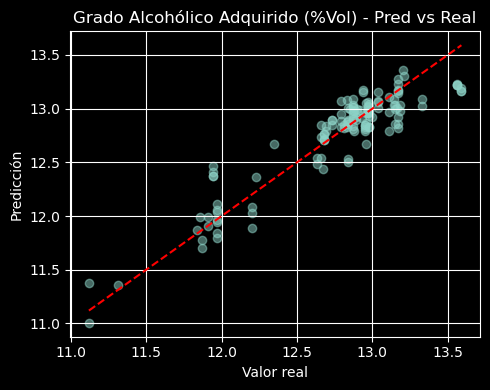

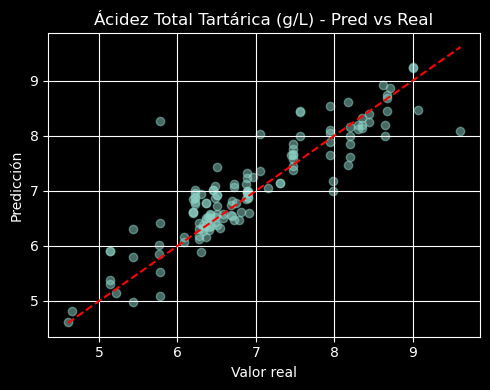

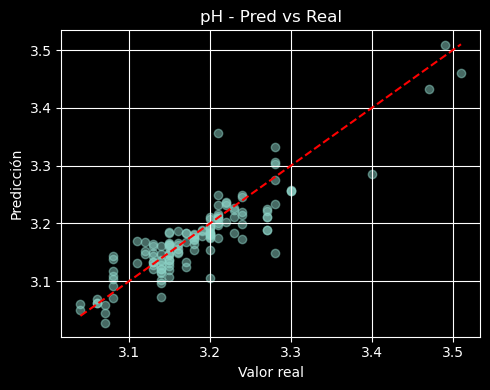

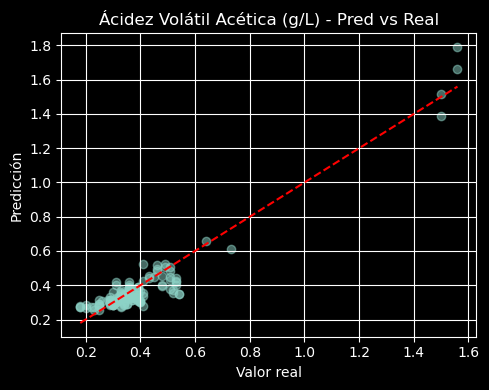

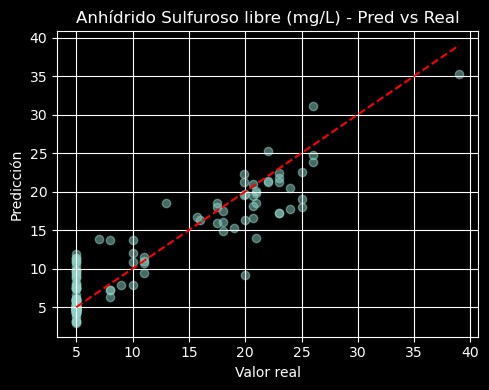

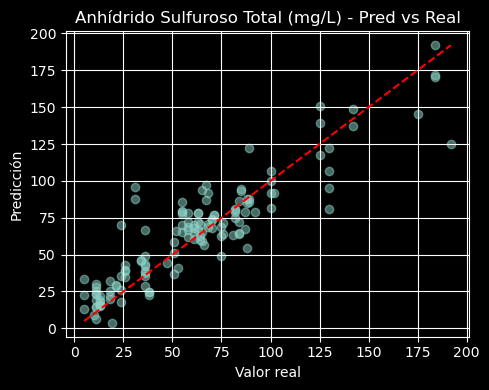

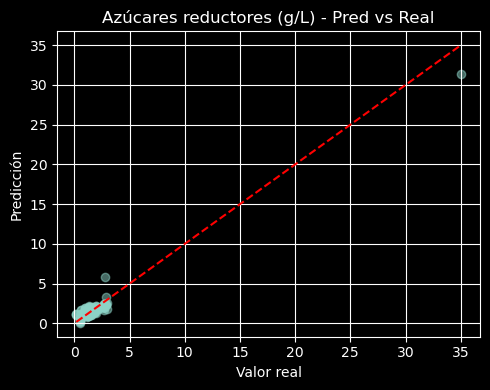

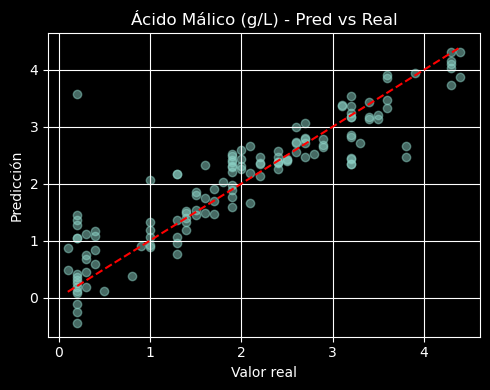


--- Total ---
R² : 0.8491401544808914
MAE: 1.9881885551025191
MSE: 39.125808040506755


In [20]:


Y_pred_scaled0 = model0.predict(X_test)

# --- Evaluación ---
Y_pred0 = scaler_y.inverse_transform(Y_pred_scaled0)
Y_test0 = scaler_y.inverse_transform(Y_test_scaled)
aux = {}
aux['r2'] = []
aux['mae'] = []
aux['mse'] = []
aux['rmse'] = []


# --- Evaluación ---
# Errores por cada salida
for i in range(N_Dimensiones_salida_Y):
    print(f"--- Output {i+1} ---")
    print("  R2 :", r2_score(Y_test0[:, i], Y_pred0[:, i]))
    aux['r2'].append(r2_score(Y_test0[:, i], Y_pred0[:, i]))
    print("MAE:", mean_absolute_error(Y_test0[:, i], Y_pred0[:, i]))
    aux['mae'].append(mean_absolute_error(Y_test0[:, i], Y_pred0[:, i]))
    print("  MSE:", mean_squared_error(Y_test0[:, i], Y_pred0[:, i]))
    aux['mse'].append(mean_squared_error(Y_test0[:, i], Y_pred0[:, i]))
    print("  RMSE:", np.sqrt(mean_squared_error(Y_test0[:, i], Y_pred0[:, i])))
    aux['rmse'].append(np.sqrt(mean_squared_error(Y_test0[:, i], Y_pred0[:, i])))
aux = pd.DataFrame(aux)

import matplotlib.pyplot as plt

for i in range(N_Dimensiones_salida_Y):
    plt.figure(figsize=(5,4))
    plt.scatter(Y_test0[:, i], Y_pred0[:, i], alpha=0.5)
    plt.plot([Y_test0[:, i].min(), Y_test0[:, i].max()],
             [Y_test0[:, i].min(), Y_test0[:, i].max()],
             'r--')
    plt.xlabel("Valor real")
    plt.ylabel("Predicción")
    plt.title(f"{dfy.keys()[i]} - Pred vs Real")
    plt.grid()
    plt.tight_layout()
    plt.show()
    
mae_total0 = mean_absolute_error(Y_test0.flatten(), Y_pred0.flatten())
mse_total0 = mean_squared_error(Y_test0.flatten(), Y_pred0.flatten())
r2_total0 = r2_score(Y_test0, Y_pred0)

print("\n--- Total ---")
print("R² :", r2_total0)
print("MAE:", mae_total0)
print("MSE:", mse_total0)

## Strategy Scope (GPU+RAM)

In [21]:

# --- Red neuronal regresora multisalida ---
start_time = time()
early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, factor=0.5)
with strategy0.scope():
    # Definir el modelo
    model1 = Sequential(
        [
            InputLayer(input_shape=(N_Dimensiones_entrada_X,)),  # Capa de entrada con 8000 características
            BatchNormalization(),  # Normalización por lotes para mejorar la convergencia
            LeakyReLU(0.5),
            Dense(512, activation="leaky_relu", kernel_regularizer=l2(0.001)),  # Capa oculta con 1024 neuronas
            Dropout(0.2),  # Capa de abandono para evitar el sobreajuste
            LeakyReLU(0.25),
            Dense(128, activation="leaky_relu"),  # Otra capa oculta con 512 neuronas
            Dropout(0.1),  # Capa de abandono para evitar el sobreajuste
            Dense(16, activation="relu", kernel_regularizer=l2(0.001)),  # Otra capa oculta con 256 neuronas
            Dense(N_Dimensiones_salida_Y),  # Capa de salida con 8 valores (Target)
        ]
    )

    adam = Adam(learning_rate=0.001)
    # Compilar el modelo
    model1.compile(optimizer=adam , loss=["mse", "mse", "mse", "mse", "mse", "mse", "mse", "mse"], loss_weights=(0.1,1,1,1,1,1,1,1), metrics=["mae","mse"])  # Función de pérdida MSE y métricas MAE y MSE
end_time = time()
print(f"Tiempo de compilacion del modelo 1: {end_time - start_time:.2f} segundos")

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [22]:

# Resumen del modelo
model1.summary()
start_time = time()
# --- Entrenamiento ---
history1 = model1.fit(X_train, Y_train_scaled, epochs=500, batch_size=32, validation_data=(X_test, Y_test_scaled), verbose=1, callbacks=[early, reduce_lr])
stop_time = time()
print(f"Tiempo de entrenamiento del modelo 1: {stop_time - start_time:.2f} segundos")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 800)              3200      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 800)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               410112    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                      

5/5 [==============================] - 1s 5ms/step
--- Output 1 ---
  R2 : 0.4738341827766771
MAE: 0.25628123163293914
  MSE: 0.1212396732580382
  RMSE: 0.348194878276574
--- Output 2 ---
  R2 : 0.5400652628086859
MAE: 0.5393207480819138
  MSE: 0.45930979124574955
  RMSE: 0.6777239786563182
--- Output 3 ---
  R2 : 0.5774400452546955
MAE: 0.03547355757819283
  MSE: 0.0025250096179753488
  RMSE: 0.050249473807944985
--- Output 4 ---
  R2 : 0.8742118039928025
MAE: 0.058749427685031184
  MSE: 0.005940802913160426
  RMSE: 0.07707660418804416
--- Output 5 ---
  R2 : 0.5789177148289646
MAE: 3.954143293875235
  MSE: 24.989921511706168
  RMSE: 4.998992049574211
--- Output 6 ---
  R2 : 0.37756750165934505
MAE: 24.32939899585865
  MSE: 1031.05012689741
  RMSE: 32.10996927587148
--- Output 7 ---
  R2 : 0.22183563764890268
MAE: 0.9914757846196494
  MSE: 6.818093670315709
  RMSE: 2.6111479602496117
--- Output 8 ---
  R2 : 0.7047479207537193
MAE: 0.5200340977973408
  MSE: 0.4345550073065366
  RMSE: 0

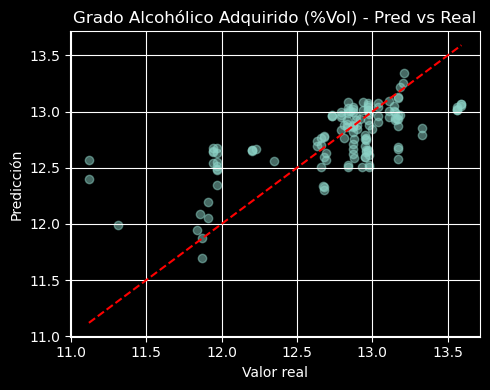

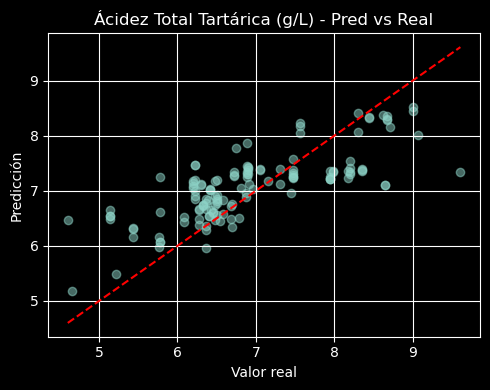

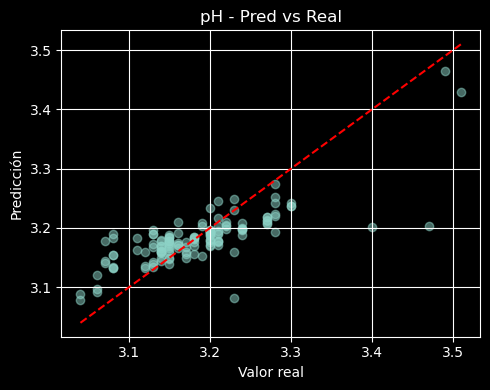

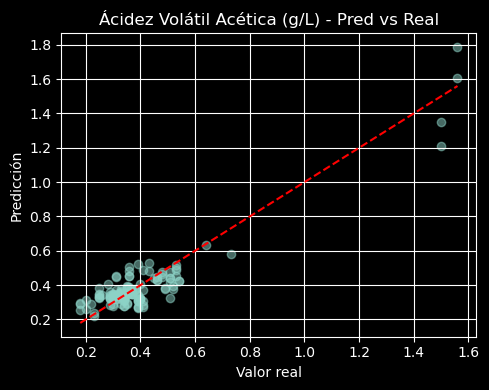

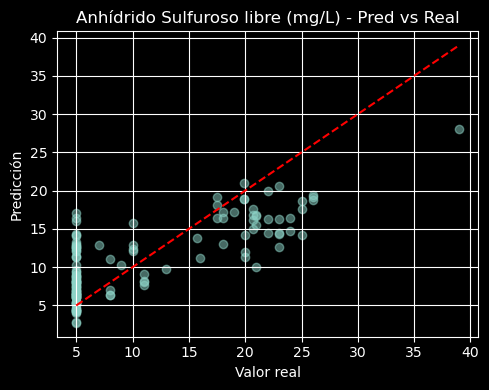

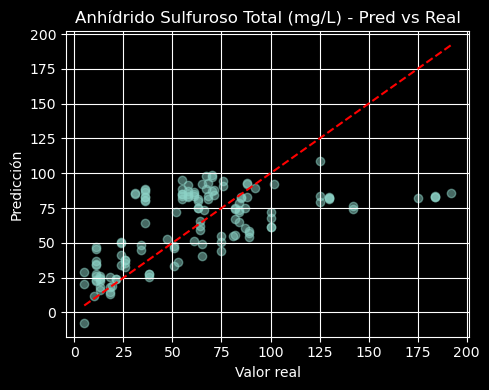

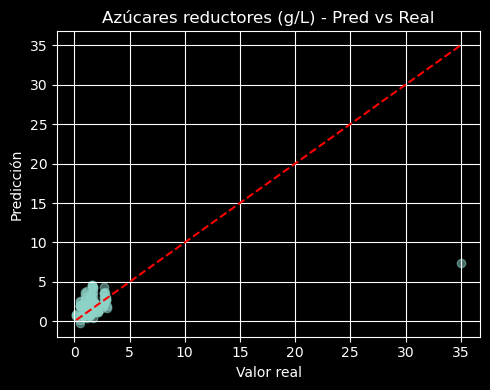

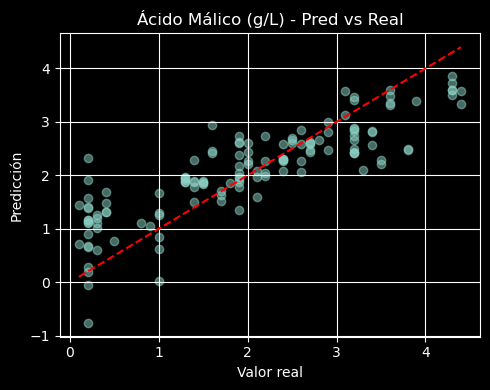


--- Total ---
R² : 0.543577508715474
MAE: 3.835609642141119
MSE: 132.98521404547168


In [23]:




Y_pred_scaled1 = model1.predict(X_test)

# --- Evaluación ---
Y_pred1 = scaler_y.inverse_transform(Y_pred_scaled1)
Y_test1 = scaler_y.inverse_transform(Y_test_scaled)
aux = {}
aux['r2'] = []
aux['mae'] = []
aux['mse'] = []
aux['rmse'] = []


# --- Evaluación ---
# Errores por cada salida
for i in range(N_Dimensiones_salida_Y):
    print(f"--- Output {i+1} ---")
    print("  R2 :", r2_score(Y_test1[:, i], Y_pred1[:, i]))
    aux['r2'].append(r2_score(Y_test1[:, i], Y_pred1[:, i]))
    print("MAE:", mean_absolute_error(Y_test1[:, i], Y_pred1[:, i]))
    aux['mae'].append(mean_absolute_error(Y_test1[:, i], Y_pred1[:, i]))
    print("  MSE:", mean_squared_error(Y_test1[:, i], Y_pred1[:, i]))
    aux['mse'].append(mean_squared_error(Y_test1[:, i], Y_pred1[:, i]))
    print("  RMSE:", np.sqrt(mean_squared_error(Y_test1[:, i], Y_pred1[:, i])))
    aux['rmse'].append(np.sqrt(mean_squared_error(Y_test1[:, i], Y_pred1[:, i])))
aux = pd.DataFrame(aux)

import matplotlib.pyplot as plt

for i in range(N_Dimensiones_salida_Y):
    plt.figure(figsize=(5,4))
    plt.scatter(Y_test1[:, i], Y_pred1[:, i], alpha=0.5)
    plt.plot([Y_test1[:, i].min(), Y_test1[:, i].max()],
             [Y_test1[:, i].min(), Y_test1[:, i].max()],
             'r--')
    plt.xlabel("Valor real")
    plt.ylabel("Predicción")
    plt.title(f"{dfy.keys()[i]} - Pred vs Real")
    plt.grid()
    plt.tight_layout()
    plt.show()
    
mae_total1 = mean_absolute_error(Y_test1.flatten(), Y_pred1.flatten())
mse_total1 = mean_squared_error(Y_test1.flatten(), Y_pred1.flatten())
r2_total1 = r2_score(Y_test1, Y_pred1)

print("\n--- Total ---")
print("R² :", r2_total1)
print("MAE:", mae_total1)
print("MSE:", mse_total1)




## Strategy Scope (GPU+RAM)

In [24]:

# --- Red neuronal regresora multisalida ---
start_time = time()
early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, factor=0.5)
with strategy1.scope():
    # Definir el modelo
    model1 = Sequential(
        [
            InputLayer(input_shape=(N_Dimensiones_entrada_X,)),  # Capa de entrada con 8000 características
            BatchNormalization(),  # Normalización por lotes para mejorar la convergencia
            LeakyReLU(0.5),
            Dense(512, activation="leaky_relu", kernel_regularizer=l2(0.001)),  # Capa oculta con 1024 neuronas
            Dropout(0.2),  # Capa de abandono para evitar el sobreajuste
            LeakyReLU(0.25),
            Dense(128, activation="leaky_relu"),  # Otra capa oculta con 512 neuronas
            Dropout(0.1),  # Capa de abandono para evitar el sobreajuste
            Dense(16, activation="relu", kernel_regularizer=l2(0.001)),  # Otra capa oculta con 256 neuronas
            Dense(N_Dimensiones_salida_Y),  # Capa de salida con 8 valores (Target)
        ]
    )

    adam = Adam(learning_rate=0.001)
    # Compilar el modelo
    model1.compile(optimizer=adam , loss=["mse", "mse", "mse", "mse", "mse", "mse", "mse", "mse"], loss_weights=(0.1,1,1,1,1,1,1,1), metrics=["mae","mse"])  # Función de pérdida MSE y métricas MAE y MSE
end_time = time()
print(f"Tiempo de compilacion del modelo 1: {end_time - start_time:.2f} segundos")

Tiempo de compilacion del modelo 1: 0.23 segundos


In [25]:

# Resumen del modelo
model1.summary()
start_time = time()
# --- Entrenamiento ---
history1 = model1.fit(X_train, Y_train_scaled, epochs=500, batch_size=32, validation_data=(X_test, Y_test_scaled), verbose=1, callbacks=[early, reduce_lr])
stop_time = time()
print(f"Tiempo de entrenamiento del modelo 1: {stop_time - start_time:.2f} segundos")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 800)              3200      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 800)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               410112    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               65664     
                                                      

5/5 [==============================] - 1s 5ms/step
--- Output 1 ---
  R2 : 0.40686153731699914
MAE: 0.26186472603126826
  MSE: 0.136671579677971
  RMSE: 0.36969119502359127
--- Output 2 ---
  R2 : 0.5525475355705388
MAE: 0.5452219821788646
  MSE: 0.4468444790331294
  RMSE: 0.6684642690773602
--- Output 3 ---
  R2 : 0.6107917729675933
MAE: 0.034708210062097636
  MSE: 0.0023257161631520655
  RMSE: 0.048225679499122306
--- Output 4 ---
  R2 : 0.8597125762077462
MAE: 0.062305998214968926
  MSE: 0.006625581432912074
  RMSE: 0.08139767461612202
--- Output 5 ---
  R2 : 0.578325537892882
MAE: 3.8969261430811004
  MSE: 25.025065367610093
  RMSE: 5.0025059088031165
--- Output 6 ---
  R2 : 0.5326588298291451
MAE: 21.990957980685764
  MSE: 774.1436607079731
  RMSE: 27.82343725545018
--- Output 7 ---
  R2 : 0.867913863204765
MAE: 0.6584479330380757
  MSE: 1.1573077575784927
  RMSE: 1.0757823932275954
--- Output 8 ---
  R2 : 0.6827269427014047
MAE: 0.5560266101801837
  MSE: 0.46696570633649515
  RMS

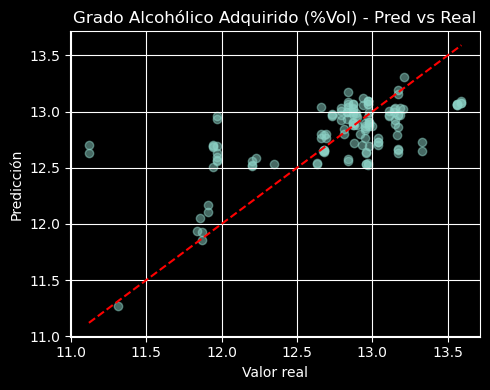

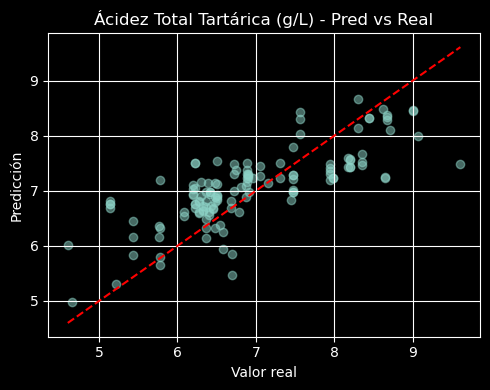

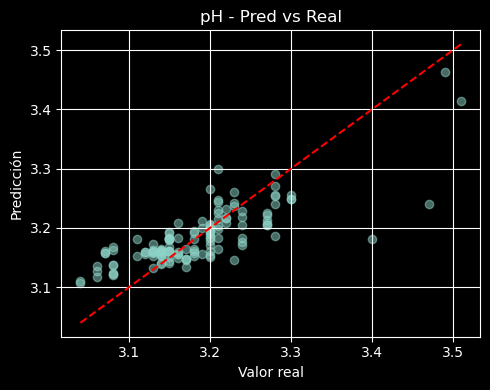

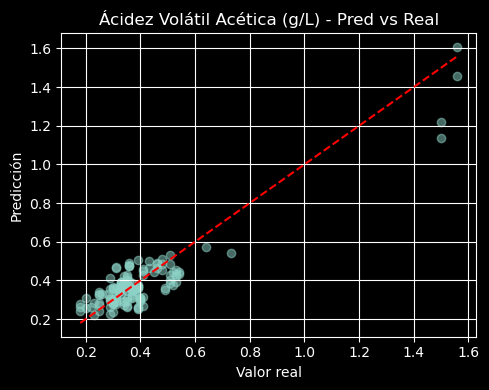

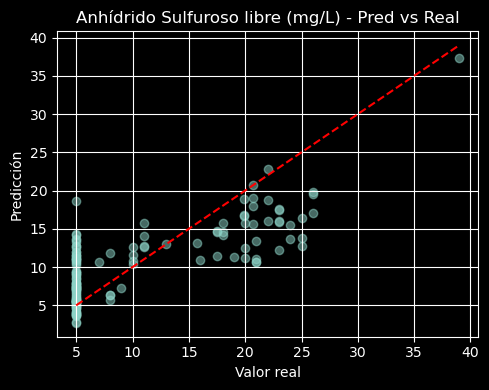

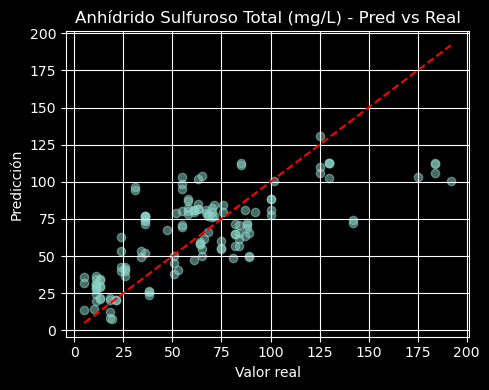

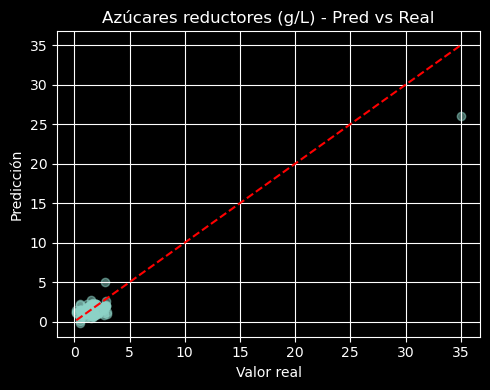

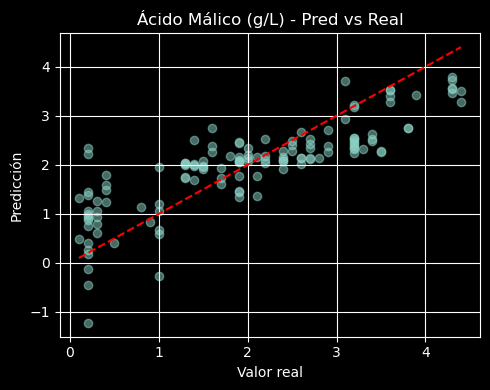


--- Total ---
R² : 0.6364423244613842
MAE: 3.50080744793404
MSE: 100.17318336197567


In [26]:




Y_pred_scaled1 = model1.predict(X_test)

# --- Evaluación ---
Y_pred1 = scaler_y.inverse_transform(Y_pred_scaled1)
Y_test1 = scaler_y.inverse_transform(Y_test_scaled)
aux = {}
aux['r2'] = []
aux['mae'] = []
aux['mse'] = []
aux['rmse'] = []


# --- Evaluación ---
# Errores por cada salida
for i in range(N_Dimensiones_salida_Y):
    print(f"--- Output {i+1} ---")
    print("  R2 :", r2_score(Y_test1[:, i], Y_pred1[:, i]))
    aux['r2'].append(r2_score(Y_test1[:, i], Y_pred1[:, i]))
    print("MAE:", mean_absolute_error(Y_test1[:, i], Y_pred1[:, i]))
    aux['mae'].append(mean_absolute_error(Y_test1[:, i], Y_pred1[:, i]))
    print("  MSE:", mean_squared_error(Y_test1[:, i], Y_pred1[:, i]))
    aux['mse'].append(mean_squared_error(Y_test1[:, i], Y_pred1[:, i]))
    print("  RMSE:", np.sqrt(mean_squared_error(Y_test1[:, i], Y_pred1[:, i])))
    aux['rmse'].append(np.sqrt(mean_squared_error(Y_test1[:, i], Y_pred1[:, i])))
aux = pd.DataFrame(aux)

import matplotlib.pyplot as plt

for i in range(N_Dimensiones_salida_Y):
    plt.figure(figsize=(5,4))
    plt.scatter(Y_test1[:, i], Y_pred1[:, i], alpha=0.5)
    plt.plot([Y_test1[:, i].min(), Y_test1[:, i].max()],
             [Y_test1[:, i].min(), Y_test1[:, i].max()],
             'r--')
    plt.xlabel("Valor real")
    plt.ylabel("Predicción")
    plt.title(f"{dfy.keys()[i]} - Pred vs Real")
    plt.grid()
    plt.tight_layout()
    plt.show()
    
mae_total1 = mean_absolute_error(Y_test1.flatten(), Y_pred1.flatten())
mse_total1 = mean_squared_error(Y_test1.flatten(), Y_pred1.flatten())
r2_total1 = r2_score(Y_test1, Y_pred1)

print("\n--- Total ---")
print("R² :", r2_total1)
print("MAE:", mae_total1)
print("MSE:", mse_total1)




## Strategy Scope (GPU+RAM)

In [27]:

# --- Red neuronal regresora multisalida ---
start_time = time()
early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, factor=0.5)
with strategy2.scope():
    # Definir el modelo
    model1 = Sequential(
        [
            InputLayer(input_shape=(N_Dimensiones_entrada_X,)),  # Capa de entrada con 8000 características
            BatchNormalization(),  # Normalización por lotes para mejorar la convergencia
            LeakyReLU(0.5),
            Dense(512, activation="leaky_relu", kernel_regularizer=l2(0.001)),  # Capa oculta con 1024 neuronas
            Dropout(0.2),  # Capa de abandono para evitar el sobreajuste
            LeakyReLU(0.25),
            Dense(128, activation="leaky_relu"),  # Otra capa oculta con 512 neuronas
            Dropout(0.1),  # Capa de abandono para evitar el sobreajuste
            Dense(16, activation="relu", kernel_regularizer=l2(0.001)),  # Otra capa oculta con 256 neuronas
            Dense(N_Dimensiones_salida_Y),  # Capa de salida con 8 valores (Target)
        ]
    )

    adam = Adam(learning_rate=0.001)
    # Compilar el modelo
    model1.compile(optimizer=adam , loss=["mse", "mse", "mse", "mse", "mse", "mse", "mse", "mse"], loss_weights=(0.1,1,1,1,1,1,1,1), metrics=["mae","mse"])  # Función de pérdida MSE y métricas MAE y MSE
end_time = time()
print(f"Tiempo de compilacion del modelo 1: {end_time - start_time:.2f} segundos")

Tiempo de compilacion del modelo 1: 0.21 segundos


In [28]:

# Resumen del modelo
model1.summary()
start_time = time()
# --- Entrenamiento ---
history1 = model1.fit(X_train, Y_train_scaled, epochs=500, batch_size=32, validation_data=(X_test, Y_test_scaled), verbose=1, callbacks=[early, reduce_lr])
stop_time = time()
print(f"Tiempo de entrenamiento del modelo 1: {stop_time - start_time:.2f} segundos")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 800)              3200      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 800)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               410112    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                      

5/5 [==============================] - 1s 5ms/step
--- Output 1 ---
  R2 : 0.43092107715279837
MAE: 0.27206941053602435
  MSE: 0.13112775555837225
  RMSE: 0.3621156659941299
--- Output 2 ---
  R2 : 0.5695993949031128
MAE: 0.4999967063621239
  MSE: 0.42981578927113245
  RMSE: 0.6556033780199217
--- Output 3 ---
  R2 : 0.5736013454740909
MAE: 0.03649652156123411
  MSE: 0.002547947792210029
  RMSE: 0.050477200716858586
--- Output 4 ---
  R2 : 0.8553155164093635
MAE: 0.06178610297044118
  MSE: 0.006833248499367803
  RMSE: 0.0826634653239737
--- Output 5 ---
  R2 : 0.6115962646117996
MAE: 3.7628985659281415
  MSE: 23.05055141006979
  RMSE: 4.801098979407714
--- Output 6 ---
  R2 : 0.48509009622572996
MAE: 21.838695130524812
  MSE: 852.9405566748476
  RMSE: 29.205146064946288
--- Output 7 ---
  R2 : 0.8971483805001732
MAE: 0.5900635806896068
  MSE: 0.9011617722697675
  RMSE: 0.9492954083264953
--- Output 8 ---
  R2 : 0.6828837557489273
MAE: 0.5256738676406718
  MSE: 0.46673490730135897
  RMS

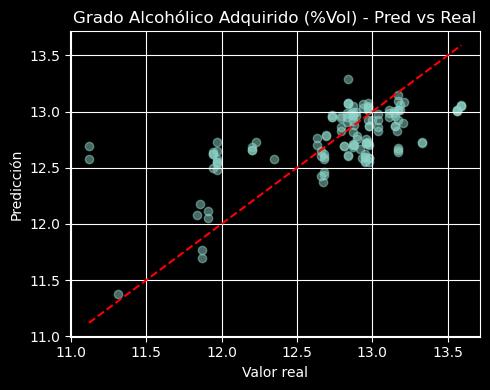

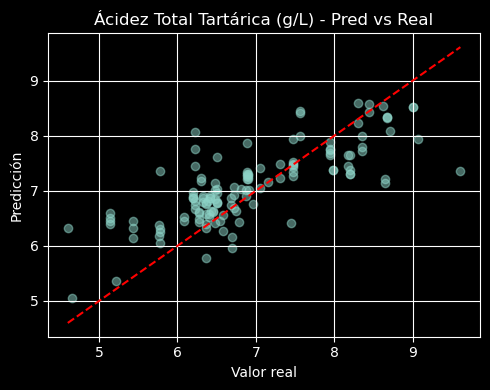

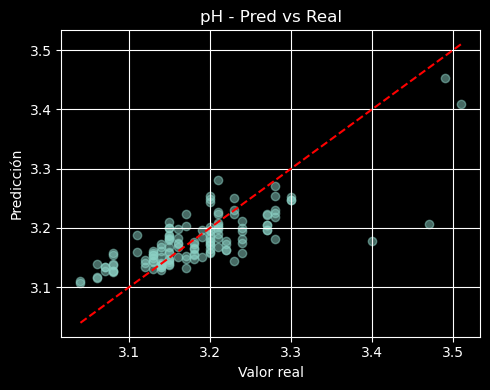

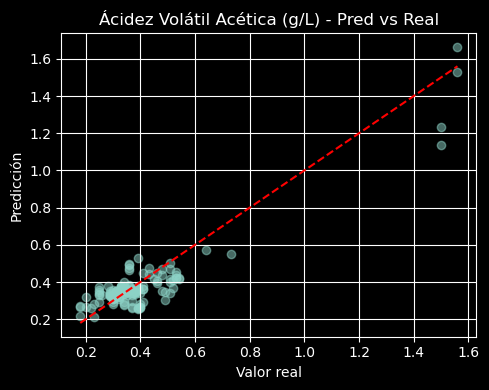

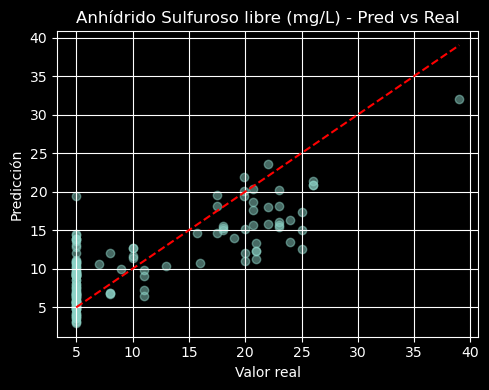

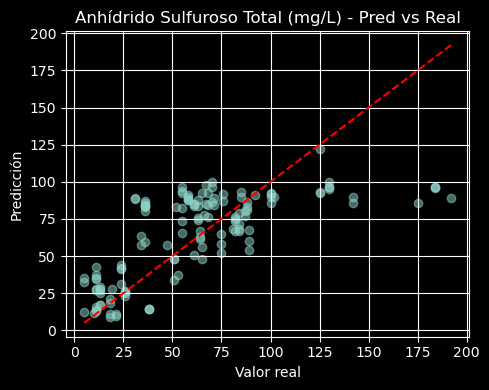

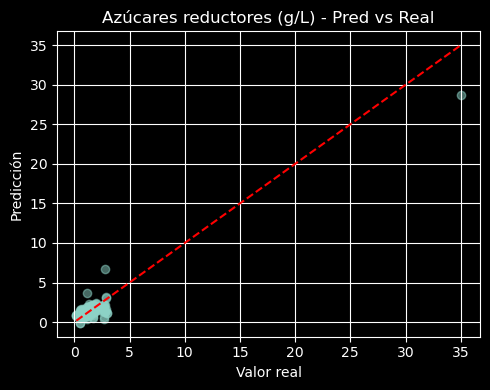

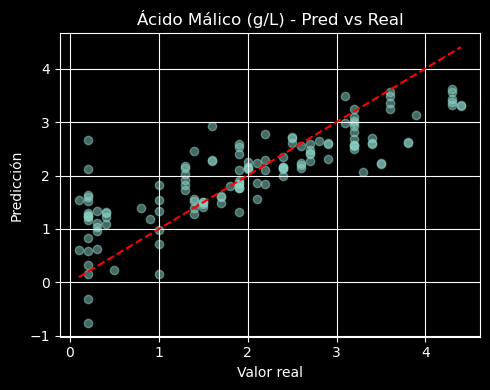


--- Total ---
R² : 0.6382694788782493
MAE: 3.4484599857766316
MSE: 109.7411661882012


In [29]:




Y_pred_scaled1 = model1.predict(X_test)

# --- Evaluación ---
Y_pred1 = scaler_y.inverse_transform(Y_pred_scaled1)
Y_test1 = scaler_y.inverse_transform(Y_test_scaled)
aux = {}
aux['r2'] = []
aux['mae'] = []
aux['mse'] = []
aux['rmse'] = []


# --- Evaluación ---
# Errores por cada salida
for i in range(N_Dimensiones_salida_Y):
    print(f"--- Output {i+1} ---")
    print("  R2 :", r2_score(Y_test1[:, i], Y_pred1[:, i]))
    aux['r2'].append(r2_score(Y_test1[:, i], Y_pred1[:, i]))
    print("MAE:", mean_absolute_error(Y_test1[:, i], Y_pred1[:, i]))
    aux['mae'].append(mean_absolute_error(Y_test1[:, i], Y_pred1[:, i]))
    print("  MSE:", mean_squared_error(Y_test1[:, i], Y_pred1[:, i]))
    aux['mse'].append(mean_squared_error(Y_test1[:, i], Y_pred1[:, i]))
    print("  RMSE:", np.sqrt(mean_squared_error(Y_test1[:, i], Y_pred1[:, i])))
    aux['rmse'].append(np.sqrt(mean_squared_error(Y_test1[:, i], Y_pred1[:, i])))
aux = pd.DataFrame(aux)

import matplotlib.pyplot as plt

for i in range(N_Dimensiones_salida_Y):
    plt.figure(figsize=(5,4))
    plt.scatter(Y_test1[:, i], Y_pred1[:, i], alpha=0.5)
    plt.plot([Y_test1[:, i].min(), Y_test1[:, i].max()],
             [Y_test1[:, i].min(), Y_test1[:, i].max()],
             'r--')
    plt.xlabel("Valor real")
    plt.ylabel("Predicción")
    plt.title(f"{dfy.keys()[i]} - Pred vs Real")
    plt.grid()
    plt.tight_layout()
    plt.show()
    
mae_total1 = mean_absolute_error(Y_test1.flatten(), Y_pred1.flatten())
mse_total1 = mean_squared_error(Y_test1.flatten(), Y_pred1.flatten())
r2_total1 = r2_score(Y_test1, Y_pred1)

print("\n--- Total ---")
print("R² :", r2_total1)
print("MAE:", mae_total1)
print("MSE:", mse_total1)




## CPU:0

In [30]:

# --- Red neuronal regresora multisalida ---
start_time = time()
early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, factor=0.5)
with tf.device('/device:CPU:0'):
    # Definir el modelo
    model2 = Sequential(
        [
            InputLayer(input_shape=(N_Dimensiones_entrada_X,)),  # Capa de entrada con 8000 características
            BatchNormalization(),  # Normalización por lotes para mejorar la convergencia
            LeakyReLU(0.5),
            Dense(512, activation="leaky_relu", kernel_regularizer=l2(0.001)),  # Capa oculta con 1024 neuronas
            Dropout(0.2),  # Capa de abandono para evitar el sobreajuste
            LeakyReLU(0.25),
            Dense(128, activation="leaky_relu"),  # Otra capa oculta con 512 neuronas
            Dropout(0.1),  # Capa de abandono para evitar el sobreajuste
            Dense(16, activation="relu", kernel_regularizer=l2(0.001)),  # Otra capa oculta con 256 neuronas
            Dense(N_Dimensiones_salida_Y),  # Capa de salida con 8 valores (Target)
        ]
    )

    adam = Adam(learning_rate=0.001)
    # Compilar el modelo
    model2.compile(optimizer=adam , loss=["mse", "mse", "mse", "mse", "mse", "mse", "mse", "mse"], loss_weights=(0.1,1,1,1,1,1,1,1), metrics=["mae","mse"])  # Función de pérdida MSE y métricas MAE y MSE
stop_time = time()
print(f"Tiempo de compilacion del modelo 2: {stop_time - start_time:.2f} segundos")

Tiempo de compilacion del modelo 2: 0.19 segundos


In [31]:

# Resumen del modelo
model2.summary()
start_time = time()
# --- Entrenamiento ---
history2 = model2.fit(X_train, Y_train_scaled, epochs=500, batch_size=32, validation_data=(X_test, Y_test_scaled), verbose=1, callbacks=[early, reduce_lr])
stop_time = time()
print(f"Tiempo de entrenamiento del modelo 2: {stop_time - start_time:.2f} segundos")


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 800)              3200      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 800)               0         
                                                                 
 dense_16 (Dense)            (None, 512)               410112    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               65664     
                                                      

5/5 [==============================] - 0s 5ms/step
--- Output 1 ---
  R2 : 0.49979852558577753
MAE: 0.2554947097213181
  MSE: 0.11525694246198012
  RMSE: 0.33949512877503873
--- Output 2 ---
  R2 : 0.5666456020819848
MAE: 0.5234760961179381
  MSE: 0.4327655685644744
  RMSE: 0.6578491989540417
--- Output 3 ---
  R2 : 0.549532386919791
MAE: 0.03710226398044164
  MSE: 0.002691772002625067
  RMSE: 0.05188228987453298
--- Output 4 ---
  R2 : 0.859545921168819
MAE: 0.06661579159895578
  MSE: 0.0066334523204212275
  RMSE: 0.0814460086217933
--- Output 5 ---
  R2 : 0.5434651005139064
MAE: 4.201781713697645
  MSE: 27.093923699207927
  RMSE: 5.205182388659203
--- Output 6 ---
  R2 : 0.5388950808491798
MAE: 21.59067992987456
  MSE: 763.8134041376426
  RMSE: 27.63717431536087
--- Output 7 ---
  R2 : 0.5757530685700181
MAE: 0.7655105891834808
  MSE: 3.7171521310668045
  RMSE: 1.9279917352174527
--- Output 8 ---
  R2 : 0.7272692179840065
MAE: 0.4926228141177584
  MSE: 0.4014079334317524
  RMSE: 0.63

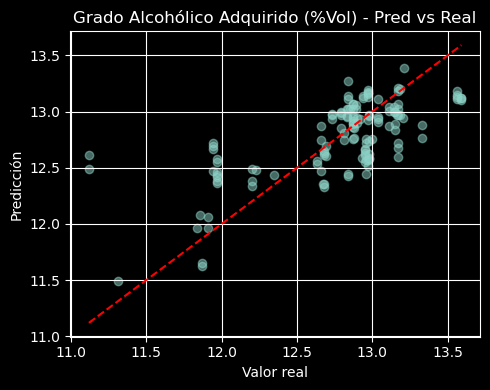

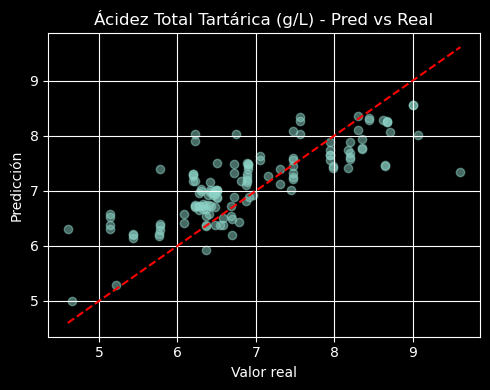

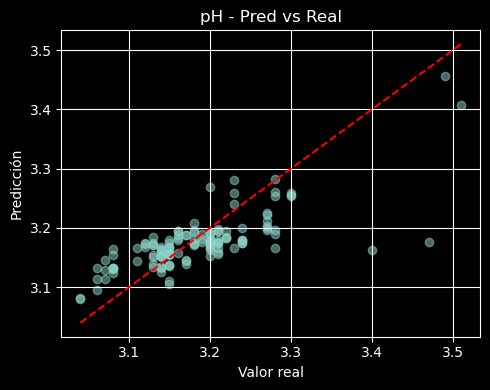

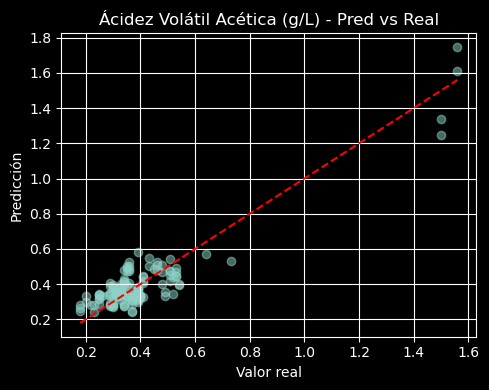

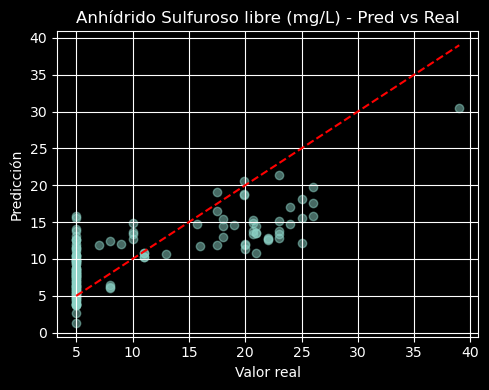

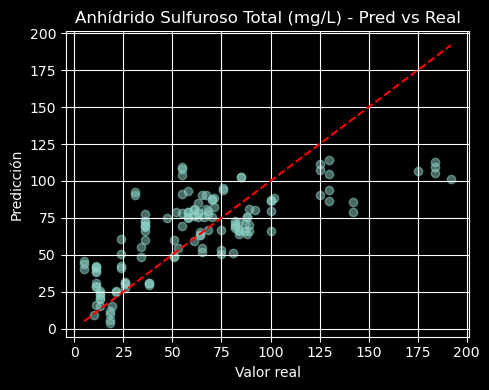

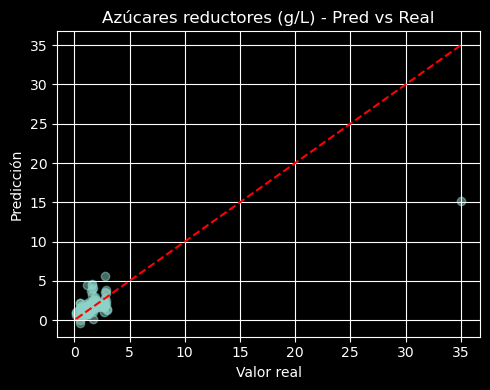

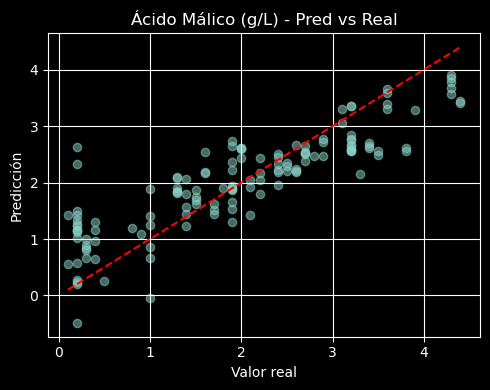


--- Total ---
R² : 0.6076131129591852
MAE: 3.4916604885365126
MSE: 99.44790445458733


In [32]:



Y_pred_scaled2 = model2.predict(X_test)

# --- Evaluación ---
Y_pred2 = scaler_y.inverse_transform(Y_pred_scaled2)
Y_test2 = scaler_y.inverse_transform(Y_test_scaled)
aux = {}
aux['r2'] = []
aux['mae'] = []
aux['mse'] = []
aux['rmse'] = []


# --- Evaluación ---
# Errores por cada salida
for i in range(N_Dimensiones_salida_Y):
    print(f"--- Output {i+1} ---")
    print("  R2 :", r2_score(Y_test2[:, i], Y_pred2[:, i]))
    aux['r2'].append(r2_score(Y_test2[:, i], Y_pred2[:, i]))
    print("MAE:", mean_absolute_error(Y_test2[:, i], Y_pred2[:, i]))
    aux['mae'].append(mean_absolute_error(Y_test2[:, i], Y_pred2[:, i]))
    print("  MSE:", mean_squared_error(Y_test2[:, i], Y_pred2[:, i]))
    aux['mse'].append(mean_squared_error(Y_test2[:, i], Y_pred2[:, i]))
    print("  RMSE:", np.sqrt(mean_squared_error(Y_test2[:, i], Y_pred2[:, i])))
    aux['rmse'].append(np.sqrt(mean_squared_error(Y_test2[:, i], Y_pred2[:, i])))
aux = pd.DataFrame(aux)

import matplotlib.pyplot as plt

for i in range(N_Dimensiones_salida_Y):
    plt.figure(figsize=(5,4))
    plt.scatter(Y_test2[:, i], Y_pred2[:, i], alpha=0.5)
    plt.plot([Y_test2[:, i].min(), Y_test2[:, i].max()],
             [Y_test2[:, i].min(), Y_test2[:, i].max()],
             'r--')
    plt.xlabel("Valor real")
    plt.ylabel("Predicción")
    plt.title(f"{dfy.keys()[i]} - Pred vs Real")
    plt.grid()
    plt.tight_layout()
    plt.show()
    
mae_total2 = mean_absolute_error(Y_test2.flatten(), Y_pred2.flatten())
mse_total2 = mean_squared_error(Y_test2.flatten(), Y_pred2.flatten())
r2_total2 = r2_score(Y_test2, Y_pred2)

print("\n--- Total ---")
print("R² :", r2_total2)
print("MAE:", mae_total2)
print("MSE:", mse_total2)